In [51]:
import pandas as pd
import re, string, unicodedata
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import gc
import matplotlib.pyplot as plt

In [52]:
#Loading the data
df_data = pd.read_csv('mbti_1.csv')

# Removed |||
df_data.posts = df_data.posts.replace(r'[|||]', r' ', regex=True)
df_data

,type,posts
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ...
1,ENTP,'I'm finding the lack of me in these posts ver...
2,INTP,'Good one _____ https://www.youtube.com/wat...
3,INTJ,"'Dear INTP, I enjoyed our conversation the o..."
4,ENTJ,'You're fired. That's another silly misconce...
...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908 ...
8671,ENFP,'So...if this thread already exists someplace ...
8672,INTP,'So many questions when i do these things. I ...
8673,INFP,'I am very conflicted right now when it comes ...


In [53]:
#Diving the 16 MBTI type to only 4
df_data['is_E'] = df_data['type'].apply(lambda x: 1 if x[0] == 'E' else 0)
df_data['is_S'] = df_data['type'].apply(lambda x: 1 if x[1] == 'S' else 0)
df_data['is_T'] = df_data['type'].apply(lambda x: 1 if x[2] == 'T' else 0)
df_data['is_J'] = df_data['type'].apply(lambda x: 1 if x[3] == 'J' else 0)
df_data

,type,posts,is_E,is_S,is_T,is_J
0,INFJ,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,ENTP,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,INTP,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,INTJ,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,ENTJ,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...,...
8670,ISFP,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,ENFP,'So...if this thread already exists someplace ...,1,0,0,0
8672,INTP,'So many questions when i do these things. I ...,0,0,1,0
8673,INFP,'I am very conflicted right now when it comes ...,0,0,0,0


In [54]:
#dropping the type column
df_data = df_data.drop(['type'], axis=1)
df_data

,posts,is_E,is_S,is_T,is_J
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,'So...if this thread already exists someplace ...,1,0,0,0
8672,'So many questions when i do these things. I ...,0,0,1,0
8673,'I am very conflicted right now when it comes ...,0,0,0,0


In [55]:
#Separating the data according to I/E , N/S, F/T AND P/J. All of them has the post column
df_data_IE = df_data.drop(['is_S', 'is_T', 'is_J'], axis=1)
df_data_NS = df_data.drop(['is_E', 'is_T', 'is_J'], axis=1)
df_data_FT = df_data.drop(['is_S', 'is_E', 'is_J'], axis=1)
df_data_PJ = df_data.drop(['is_S', 'is_T', 'is_E'], axis=1)
df_data

,posts,is_E,is_S,is_T,is_J
0,'http://www.youtube.com/watch?v=qsXHcwe3krw ...,0,0,0,1
1,'I'm finding the lack of me in these posts ver...,1,0,1,0
2,'Good one _____ https://www.youtube.com/wat...,0,0,1,0
3,"'Dear INTP, I enjoyed our conversation the o...",0,0,1,1
4,'You're fired. That's another silly misconce...,1,0,1,1
...,...,...,...,...,...
8670,'https://www.youtube.com/watch?v=t8edHB_h908 ...,0,1,0,0
8671,'So...if this thread already exists someplace ...,1,0,0,0
8672,'So many questions when i do these things. I ...,0,0,1,0
8673,'I am very conflicted right now when it comes ...,0,0,0,0


In [61]:
#Cleaning the data Round 1
def clean_text_round1(text):
    '''Make text lowercase, remove punctuation, remove words containing numbers, remove URL, remove @, '''
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('[^a-zA-Z\s]', '', text)
    text = re.sub('\w*\d\w*', '', text)
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r'@\w+', '', text)
    return text

round1 = lambda x: clean_text_round1(x)

cleanedData = pd.DataFrame(df_data.posts.apply(round1))

In [62]:
df_data['posts'] = cleanedData
df_data

,posts,is_E,is_S,is_T,is_J
0,enfp and intj moments sportscenter no...,0,0,0,1
1,im finding the lack of me in these posts very ...,1,0,1,0
2,good one of course to which i say i kno...,0,0,1,0
3,dear intp i enjoyed our conversation the oth...,0,0,1,1
4,youre fired thats another silly misconceptio...,1,0,1,1
...,...,...,...,...,...
8670,ixfp just because i always think of cats as...,0,1,0,0
8671,soif this thread already exists someplace else...,1,0,0,0
8672,so many questions when i do these things i wo...,0,0,1,0
8673,i am very conflicted right now when it comes t...,0,0,0,0


In [34]:
#X_validate_IE_clean.to_csv('cleanedvalidare_IE.csv')

In [63]:
from numpy.random import RandomState
import pandas as pd

df = df_data
rng = RandomState()

train = df.sample(frac=0.9, random_state=rng)
test = df.loc[~df.index.isin(train.index)]

In [64]:
train.to_csv('train.csv')

In [65]:
test.to_csv('test.csv')

Random under-sampling:
0    1999
1    1999
Name: is_E, dtype: int64


<AxesSubplot:title={'center':'Count (target)'}>

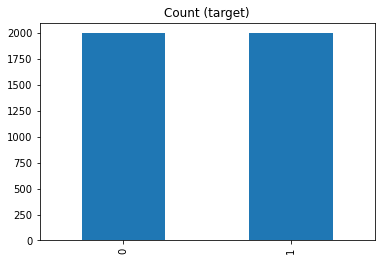

In [16]:
df_class_0_under = df_class_0.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, df_class_1], axis=0)

print('Random under-sampling:')
print(df_test_under.is_E.value_counts())

df_test_under.is_E.value_counts().plot(kind='bar', title='Count (target)')